In [1]:
# Solve problem 5 from Lagaris, Likas, and Fotiadis (1998)
# $(x,y) \in [0,1]^2$
# $$ \Delta \Psi(x,y) = f(x,y), where f(x,y) = e^{-x}(x-2+y^3+6y)$$
# Boundary conditions:
# \Psi(0,y) = y^3
# \Psi(1,y) = (1+y^3)e^{-1}
# \Psi(x,0) = xe^{-x}
# \Psi(x,1) = e^{-1}(x+1)
# Exact solution: \Psi_{exact}(x,y) = e^{-x}(x+y^3)
# Solution model: \Psi(x,y) = A(x,y) + x(1-x)y(1-y)NN(x,y;w)
# where NN(x,y;w) is a neural network of the form NN(x,y) = v * sigma(W*[x,y]^T + v)
# where v is n-by-1, W is n-by-2, v is n-by-1,
# x(1-x)y(1-y) is a function that is zero on the boundary, and 
# A(x,y) is a smooth function satisfying boundary consitions:
# A(x,y) = (1-x)y^3 + x(1+y^3)e^{-1} + (1-y)x(e^{-x}-e^{-1}) + y[(1+x)e^{-x}-(1-x+2xe^{-1})]
# Training points: {(x_i,y_i)}_{i=1}^N
# loss function: L(w) = (1/N)\sum_{i=1}^N (\Psi_{xx}(x_i,y_i) + Psi_{yy}(x_i,y_i) - f(x_i,y_i))^2

In [2]:
# import necessary packages
import numpy as np
import torch
import matplotlib.pyplot as plt
torch.set_default_dtype(torch.float64) # set arithmetic to be double precision
plt.rcParams.update({'font.size': 20}) # set font size in all plots

In [3]:
# define the exact solution
def ExactSolution(x,y):
    # y^2*sin(pi*x)
    return y.pow(2)*torch.sin(np.pi*x)

In [4]:
def prepare_data(xmin,xmax,nx,ymin,ymax,ny,strip_bdry):
    x1 = torch.linspace(xmin,xmax,steps = nx)
    y1 = torch.linspace(ymin,ymax,steps = ny)
    if strip_bdry == True:
        grid_x, grid_y = torch.meshgrid(x1[1:nx-1],y1[1:ny-1],indexing = 'ij')
    else:
        grid_x, grid_y = torch.meshgrid(x1,y1,indexing = 'ij')
    xcol = torch.reshape(grid_x,(grid_x.numel(),1))
    ycol = torch.reshape(grid_y,(grid_y.numel(),1))
    data_matrix = torch.cat((xcol,ycol),1)
    return grid_x, grid_y, data_matrix

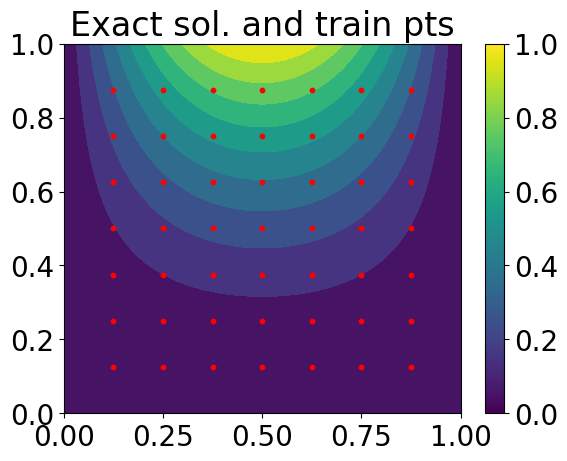

In [5]:
# define training points
npt1 = 9
strip_boundary = True
xtrain_grid, ytrain_grid, xytrain = prepare_data(0.,1.,npt1,0.,1.,npt1,strip_boundary)

# define test points
npt2 = 100
strip_boundary = False
xtest_grid, ytest_grid, xytest = prepare_data(0.,1.,npt2,0.,1.,npt2,strip_boundary)

# find the exact solution at the test points
sol_exact = ExactSolution(xtest_grid,ytest_grid)
sol_exact_vector = torch.reshape(sol_exact,(torch.numel(sol_exact),1))
sol_min = torch.min(sol_exact_vector)
sol_max = torch.max(sol_exact_vector)

# plot the exact solution and the training points
plt.figure()
plt.contourf(xtest_grid,ytest_grid,sol_exact,torch.arange(sol_min,sol_max+.01,(sol_max-sol_min)*0.1))  
plt.scatter(xytrain[:,0],xytrain[:,1],s = 10, c = '#FF0000')
plt.colorbar()
plt.title("Exact sol. and train pts")

plt.savefig("ExactSol.pdf")

In [6]:
# define activation function
def ActiveFun(x):
    # tanh
    ActFun = torch.tanh(x);
    dActFun = 1/torch.cosh(x).pow(2); # 1./cosh(x).^2
    d2ActFun = -2*torch.sinh(x)/torch.cosh(x).pow(3); # -2*sinh(x)./cosh(x).^3
    d3ActFun = (4*torch.sinh(x).pow(2)-2)/torch.cosh(x).pow(4); # (4*sinh(x).^2-2)./cosh(x).^4
    d4ActFun = (16*torch.sinh(x)-8*torch.sinh(x).pow(3))/torch.cosh(x).pow(5); # (16*sinh(x)-8sinh(x).^3)./cosh(x).^5
    return ActFun, dActFun, d2ActFun, d3ActFun, d4ActFun

In [7]:
# define solution model
# define our model and call it model_11
N_neurons = 10
# initialize parameters of NN with random numbers
W = torch.rand(N_neurons*4,1)
# i think actually
# architecture: NN(X;w) = w3 * sigma(w0*x + w1*y + w2)
# w3 is 1-by-N_neurons   X not sure about these sizes
# w2 is N_neurons-by-2   X
# w1 is Nneurons-by-1    X

def NeuralNetwork(x,y,W,derivatives):
    Nneurons = int((torch.numel(W)/4))
    # print("NN: Nneurons = ",Nneurons)
    W = torch.transpose(torch.reshape(W,(4,Nneurons)),0,1)
    z = W[:,2]+W[:,0]*x+W[:,1]*y # argument of sigma
    s0,s1,s2,s3,s4 = ActiveFun(z) # sigma(z) and its first three derivatives
    # the neural network and its derivatives with respect to x and y
    W3s1 = W[:,3]*s1;
    NN = torch.sum(W[:,3]*s0)
    if derivatives == False:
        return NN
    else:    
        NNx = torch.sum(W3s1*W[:,0])
        NNy = torch.sum(W3s1*W[:,1])
        NNxx = torch.sum(W[:,3]*(W[:,0].pow(2)*s2))
        NNyy = torch.sum(W[:,3]*(W[:,1].pow(2)*s2))
        # extra derivative for NN1xy/NN1xxy, w3*w0*w1*sigma''/w3*w0*w1^2*sigma'''
        NNxy = torch.sum(W[:,3]*(W[:,0]*W[:,1]*s2))
        NNxxy = torch.sum(W[:,3]*(W[:,1]*W[:,0].pow(2)*s3))
        # derivatives w.r.t. parameters of the neural network 
        NN_W0 = x*W3s1
        NN_W1 = y*W3s1
        NN_W2 = W3s1
        NN_W3 = s0
        NN_W = torch.cat((NN_W0,NN_W1,NN_W2,NN_W3),0) # combine derivatives into a column vector    
        # derivatives w.r.t. parameters of NNx = sum(w3*w0*s1)
        W3W0s2 = W[:,3]*W[:,0]*s2;
        NNx_W0 = W3s1 + W3W0s2*x
        NNx_W1 = W3W0s2*y
        NNx_W2 = W3W0s2
        NNx_W3 = W[:,0]*s1
        NNx_W = torch.cat((NNx_W0,NNx_W1,NNx_W2,NNx_W3),0) # combine derivatives into a column vector
        # derivatives w.r.t. parameters of NNy = sum(w3*w1*s1)
        W3W1s2 = W[:,3]*W[:,1]*s2;
        NNy_W0 = W3W1s2*x
        NNy_W1 = W3s1 + W3W1s2*y
        NNy_W2 = W3W1s2
        NNy_W3 = W[:,1]*s1
        NNy_W = torch.cat((NNy_W0,NNy_W1,NNy_W2,NNy_W3),0) # combine derivatives into a column vector
        # derivatives w.r.t. parameters of NNxy = sum(w3*w1*s1)
        W3W1W0s3 = W[:,3]*W[:,1]*s2;
        NNxy_W0 = W3W1s2 + W3W1W0s3*x
        NNxy_W1 = W3W0s2 + W3W1W0s3*y
        NNxy_W2 = W3W1W0s3
        NNxy_W3 = W[:,1]*W[:,0]*s2
        NNxy_W = torch.cat((NNxy_W0,NNxy_W1,NNxy_W2,NNxy_W3),0) # combine derivatives into a column vector
        # derivatives w.r.t. parameters of NNxx = sum(w3*w0^2*s2)
        W3W0W0s3 = W[:,3]*W[:,0].pow(2)*s3
        NNxx_W0 = 2*W3W0s2 + W3W0W0s3*x
        NNxx_W1 = W3W0W0s3*y
        NNxx_W2 = W3W0W0s3
        NNxx_W3 = W[:,0].pow(2)*s2
        NNxx_W = torch.cat((NNxx_W0,NNxx_W1,NNxx_W2,NNxx_W3),0) # combine derivatives into a column vector
        # derivatives w.r.t. parameters of NNyy = sum(w3*w1^2*s2)
        W3W1W1s3 = W[:,3]*W[:,1].pow(2)*s3
        NNyy_W0 = W3W1W1s3*x
        NNyy_W1 = 2*W3W1s2 + W3W1W1s3*y
        NNyy_W2 = W3W1W1s3
        NNyy_W3 = W[:,1].pow(2)*s2
        NNyy_W = torch.cat((NNyy_W0,NNyy_W1,NNyy_W2,NNyy_W3),0) # combine derivatives into a column vector
        # derivatives w.r.t. parameters of NNxxy = sum(w3*w1^2*s2)
        W3W1W0W0s4 = W[:,3]*W[:,1]*W[:,0].pow(2)*s3
        NNxxy_W0 = 2*W3W1W0s3 + W3W1W0W0s4*x
        NNxxy_W1 = W3W0W0s3 + W3W1W0W0s4*y
        NNxxy_W2 = W3W1W0W0s4
        NNxxy_W3 = W[:,1]*W[:,0].pow(2)*s3
        NNxxy_W = torch.cat((NNxxy_W0,NNxxy_W1,NNxxy_W2,NNxxy_W3),0) # combine derivatives into a column vector
        return NN, NNx, NNy, NNxy, NNxx, NNyy, NNxxy, NN_W, NNx_W, NNy_W, NNxy_W, NNxx_W, NNyy_W, NNxxy_W
    
def SolutionModel(x,y,W):
    # u(x,y) = B(x,y) + x(1-x)y[NN(x,y;w)-NN(x,1;w)-NN_y(x,1;w)], where
    # B(x,y) = 2*y*sin(pi*x)
    NN = NeuralNetwork(x,y,W,False)
    # need to remove NN and NN_y for y=1
    NN1, z, NNy1, a, b, c, d, e, f, g, h, i, j, k = NeuralNetwork(x,torch.ones_like(y),W,True)
    sol = 2*y*torch.sin(np.pi*x)+x*(1-x)*y*(NN-NN1-NNy1)
    return sol

def RHS(x,y):
    # (2-pi^2 y^2)sin(pi*y)
    return (2-(np.pi**2)*y.pow(2))*torch.sin(np.pi*x)


def PoissonEqSolutionModel(x,y,W):
    # computes the r = Laplacian[B(x,y) + x(1-x)y[NN(x,y;w)-NN(x,1;w)-NN_y(x,1;w)]] - RightHandSide
    # B(x,y) = 2ysin(pix)
    # XXX - was computes the r = Laplacian[A(x,y) + x(1-x)y(1-y)NN(x,y;w)] - RightHandSide
    # and the gradient of r w.r.t parameters W
    NN, NNx, NNy, NNxy, NNxx, NNyy, NNxxy, NN_W, NNx_W, NNy_W, NNxy_W, NNxx_W, NNyy_W, NNxxy_W = NeuralNetwork(x,y,W,True)
    # at y = 1
    NN1, NNx1, NNy1, NNxy1, NNxx1, NNyy1, NNxxy1, NN_W1, NNx_W1, NNy_W1, NNxy_W1, NNxx_W1, NNyy_W1, NNxxy_W1 = NeuralNetwork(x,torch.ones_like(y),W,True)
    
    Bxx = -2*y*(np.pi**2)*torch.sin(np.pi*x)
    Byy = 0
    C   = x*(1-x)*y
    Cx  = (1-2*x)*y
    Cy  = x*(1-x)
    Cxx = -2*y
#     Cyy = 0 
    uxx = Bxx + Cxx*(NN-NN1-NNy1) + 2*Cx*(NNx-NNx1-NNxy1) + C*(NNxx-NNxx1-NNxxy1)
    uyy = Byy + 2*Cy*NNy + C*NNyy
    res = uxx + uyy - RHS(x,y)
    dres_W = Cxx*(NN_W-NN_W1-NNy_W1) + 2*Cx*(NNx_W-NNx_W1-NNxy_W1) + C*(NNxx_W-NNxx_W1-NNxxy_W1) + 2*Cy*NNy_W + C*NNyy_W
    return res, dres_W

In [8]:
# form the vector of residuals and the Jacobian matrix for the set of training points
def Residual_and_Jacobian(xy,W):
    # each row of xy corresponds to a training point
    Nxy = xy.size(dim=0) # the number of training points
    NW = W.numel() # total number of entries of W
    res = torch.zeros(Nxy,1) # vector of residuals
    Jac = torch.zeros(Nxy,NW) # Jacobian matrix
    for j in range(Nxy):
        r,dr_W = PoissonEqSolutionModel(xy[j,0],xy[j,1],W)
        res[j] = r
        Jac[j,:] = dr_W
    return res, Jac    

In [9]:
# Levenverg-Marquardt
def Loss(r):
    return 0.5*torch.sum(r.pow(2)) # 0.5*sum(r^2)
    
def LevenbergMarquardt(Res_and_Jac,par,x):
    # minimizes loss = 0.5/n sum_{j=1}^n r_j^2(x)
    # constrained minimization problem solved at each step:
    # m(p) = grad^\top p + 0.5 p^\top Bmatr p --> min
    # subject to R - ||p|| >= 0
    # rho = [loss - loss(x + p)] / [loss - m(p)]
    
    # parameters for Levengerg-Marquardt
    RMAX = 1.;
    RMIN = 1e-12;
    RHO_GOOD = 0.75 # increase R is rho > RHO_GOOD
    RHO_BAD = 0.25 # decrease R is rho < RHO_BAD
    ETA = 0.01 # reject step if rho < ETA 
    ITER_MAX = 100
    TOL = 1.0e-3 # terminate when || grad loss || < tol
    
    # initialization
    r,J = Res_and_Jac(par,x)
    # print(r.size())
    # print(J.size())
    n = J.size(dim = 0) # the number of components of r
    d = J.size(dim = 1) # the number of variables
    lossvals = torch.zeros(ITER_MAX)
    gradnormvals = torch.zeros(ITER_MAX)
    lossvals[0] = Loss(r)
    Jtrans = torch.transpose(J,0,1)
    grad = torch.matmul(Jtrans,r) # grad = J^\top r
    Bmatr = torch.matmul(Jtrans,J) # Bmatr = J^\top J
    gradnorm = torch.linalg.norm(grad)
    gradnormvals[0] = gradnorm
    R = 0.2*RMAX # initial trust region radius
    print("iter 0: loss = ",lossvals[0]," gradnorm = ",gradnorm)
    # start iterations
    iter = 1
    while gradnorm > TOL and iter < ITER_MAX:
        # print(Jtrans.size())
        # print(J.size())
        # print(torch.eye(d).size())
        # print(torch.matmul(Jtrans,J).size())
        Bmatr = torch.matmul(Jtrans,J) # B = J^\top J
        p = -torch.linalg.lstsq(Bmatr,grad).solution # p = -Bmatr^{-1}grad
        norm_p = torch.linalg.norm(p)
        if norm_p > R:
            # solve grad^\top p + 0.5 p^\top Bmatr p --> min
            # subject to ||p|| = R
            gap = torch.abs(norm_p - R)
            iter_lam = 0
            lam_tol = 0.01*R
            lam = 1 # initial guess for lambda in the 1D constrained minimization problems
            while gap > lam_tol:
                B1 = Bmatr + lam*torch.eye(d) 
                C = torch.linalg.cholesky(B1) # B1 = C C^\top
                p = -torch.linalg.solve_triangular(torch.transpose(C,0,1), \
                     torch.linalg.solve_triangular(C,grad,upper = False),upper = True)
                norm_p = torch.linalg.norm(p)
                gap = torch.abs(norm_p - R)
                if gap > lam_tol:
                    q = torch.linalg.solve_triangular(C,p,upper = False)
                    norm_q = torch.linalg.norm(q)
                    lamnew = lam + (norm_p/norm_q).pow(2)*(norm_p-R)/R
                    if lamnew < 0:
                        lam = 0.5*lam
                    else:
                        lam = lamnew
                    iter_lam = iter_lam + 1
                    gap = torch.abs(norm_p - R)
            print("LM, iter ",iter,":", iter_lam," substeps")
        else:
            print("LM, iter ",iter,": steps to the model's minimum")
        # evaluate the progres
        # print("size of x: ",x.size())
        # print("size of p: ",p.size())
        xnew = x + p
        # print("size of xnew: ",xnew.size())
        rnew,Jnew = Res_and_Jac(par,xnew)  
        # print("rnew: ",rnew.size())
        # print("Jnew: ",Jnew.size())
        lossnew = Loss(rnew)
        rho = -(lossvals[iter-1] - lossnew)/(torch.sum(grad*p) + 0.5*sum(p*torch.matmul(Bmatr,p)))   
        # adjust the trust region radius
        if rho < RHO_BAD:
            R = torch.max(torch.tensor([RMIN,0.25*R]))
        elif rho > RHO_GOOD:
            R = torch.min(torch.tensor([RMAX,2.0*R]))                                       
        # accept or reject the step
        if rho > ETA:
            x = xnew
            r = rnew
            J = Jnew  
            Jtrans = torch.transpose(J,0,1)
            grad = torch.matmul(Jtrans,r)                                       
            gradnorm = torch.linalg.norm(grad)
        lossvals[iter] = lossnew
        gradnormvals[iter] = gradnorm
        print("LM, iter ",iter,": loss = ",lossvals[iter]," gradnorm = ",gradnorm," rho = ",rho," R = ",R)
        iter = iter + 1                                           
    return x,iter,lossvals[0:iter], gradnormvals[0:iter]                                                  

In [10]:
# test gradient
# dW = torch.zeros_like(W)
# delta = 1e-3
# jstar = 12
# dW[jstar] = 1
# # NN, NNx, NNy, NNxx, NNyy, NN_W, NNx_W, NNy_W, NNxx_W, NNyy_W = NeuralNetwork(xytrain[0,0],xytrain[0,1],W,True)
# # NN1, NNx1, NNy1, NNxx1, NNyy1, NN_W1, NNx_W1, NNy_W1, NNxx_W1, NNyy_W1 = NeuralNetwork(xytrain[0,0],xytrain[0,1],W+delta*dW,True)
# # NNm1, NNxm1, NNym1, NNxxm1, NNyym1, NN_Wm1, NNx_Wm1, NNy_Wm1, NNxx_Wm1, NNyy_Wm1 = NeuralNetwork(xytrain[0,0],xytrain[0,1],W-delta*dW,True)
# # print("NN: ",0.5*(NN1-NNm1)/delta," NN_W: ",NN_W[jstar])
# # print("NNx: ",0.5*(NNx1-NNxm1)/delta," NNx_W: ",NNx_W[jstar])
# # print("NNy: ",0.5*(NNy1-NNym1)/delta," NNy_W: ",NNy_W[jstar])
# # print("NNxx: ",0.5*(NNxx1-NNxxm1)/delta," NNxx_W: ",NNxx_W[jstar])
# # print("NNyy: ",0.5*(NNyy1-NNyym1)/delta," NNyy_W: ",NNyy_W[jstar])
# r,J = Residual_and_Jacobian(xytrain,W)
# r1,J1 = Residual_and_Jacobian(xytrain,W+delta*dW)
# rm1,Jm1 = Residual_and_Jacobian(xytrain,W-delta*dW)
# dr0 = 0.5*(r1-rm1)/delta
# print(dr0)
# print(J[:,jstar])


iter 0: loss =  tensor(812.5957)  gradnorm =  tensor(344.8647)
LM, iter  1 : 3  substeps
LM, iter  1 : loss =  tensor(741.5788)  gradnorm =  tensor(373.8702)  rho =  tensor([1.0557])  R =  tensor(0.4000)
LM, iter  2 : 3  substeps
LM, iter  2 : loss =  tensor(583.8311)  gradnorm =  tensor(422.6129)  rho =  tensor([1.1197])  R =  tensor(0.8000)
LM, iter  3 : 3  substeps
LM, iter  3 : loss =  tensor(266.7982)  gradnorm =  tensor(386.3837)  rho =  tensor([1.1285])  R =  tensor(1.)
LM, iter  4 : 4  substeps
LM, iter  4 : loss =  tensor(81.5367)  gradnorm =  tensor(86.7310)  rho =  tensor([0.9707])  R =  tensor(1.)
LM, iter  5 : 3  substeps
LM, iter  5 : loss =  tensor(32.7528)  gradnorm =  tensor(231.8358)  rho =  tensor([1.3672])  R =  tensor(1.)
LM, iter  6 : 1  substeps
LM, iter  6 : loss =  tensor(144.6890)  gradnorm =  tensor(231.8358)  rho =  tensor([-3.5369])  R =  tensor(0.2500)
LM, iter  7 : 4  substeps
LM, iter  7 : loss =  tensor(31.1567)  gradnorm =  tensor(156.6209)  rho =  ten

LM, iter  60 : loss =  tensor(0.0859)  gradnorm =  tensor(1.0495)  rho =  tensor([0.4728])  R =  tensor(0.0156)
LM, iter  61 : 2  substeps
LM, iter  61 : loss =  tensor(0.0846)  gradnorm =  tensor(1.0396)  rho =  tensor([0.4836])  R =  tensor(0.0156)
LM, iter  62 : 2  substeps
LM, iter  62 : loss =  tensor(0.0833)  gradnorm =  tensor(1.0289)  rho =  tensor([0.4963])  R =  tensor(0.0156)
LM, iter  63 : 2  substeps
LM, iter  63 : loss =  tensor(0.0819)  gradnorm =  tensor(1.0176)  rho =  tensor([0.5108])  R =  tensor(0.0156)
LM, iter  64 : 2  substeps
LM, iter  64 : loss =  tensor(0.0806)  gradnorm =  tensor(1.0061)  rho =  tensor([0.5269])  R =  tensor(0.0156)
LM, iter  65 : 2  substeps
LM, iter  65 : loss =  tensor(0.0793)  gradnorm =  tensor(0.9948)  rho =  tensor([0.5442])  R =  tensor(0.0156)
LM, iter  66 : 2  substeps
LM, iter  66 : loss =  tensor(0.0780)  gradnorm =  tensor(0.9846)  rho =  tensor([0.5619])  R =  tensor(0.0156)
LM, iter  67 : 2  substeps
LM, iter  67 : loss =  tens

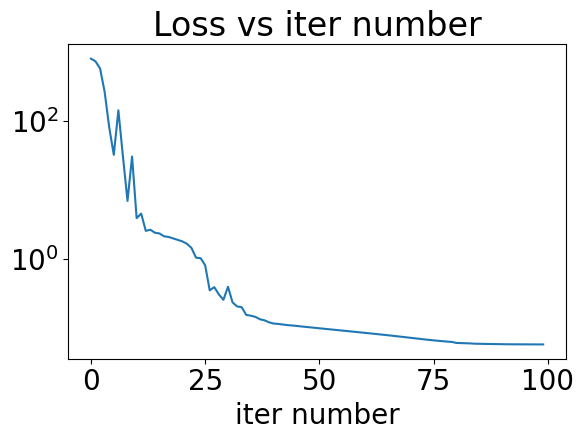

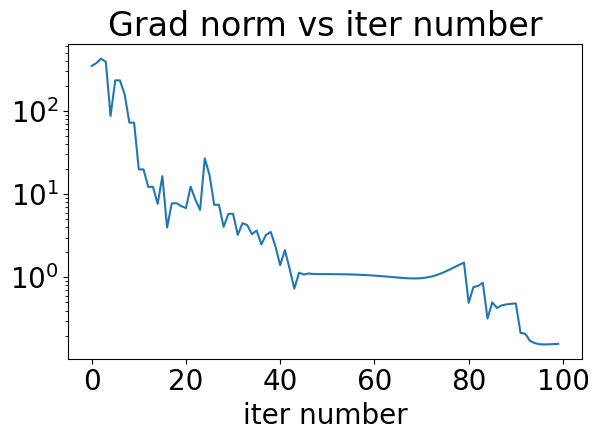

In [11]:
# train neural network
W,Niter,lossvals,gradnormvals = LevenbergMarquardt(Residual_and_Jacobian,xytrain,W)
# plot the loss and the norm of the gradient of the loss
plt.figure()
plt.plot(torch.arange(Niter),lossvals)
plt.title("Loss vs iter number")
plt.yscale("log")
plt.xlabel("iter number")
plt.tight_layout()
plt.savefig("NNLoss.pdf")
plt.figure()
plt.plot(np.arange(Niter),gradnormvals)
plt.title("Grad norm vs iter number")
plt.yscale("log")
plt.xlabel("iter number")
plt.tight_layout()
plt.savefig("NormGrad.pdf")

Max error =  tensor(0.0031)
Mean error =  tensor(0.0006)
RMS error =  tensor(0.0008)


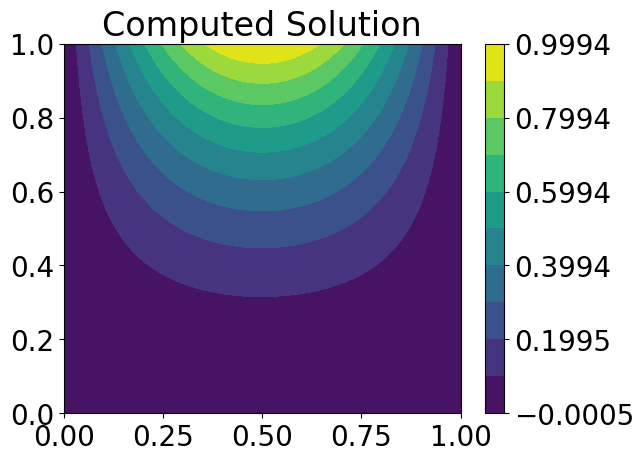

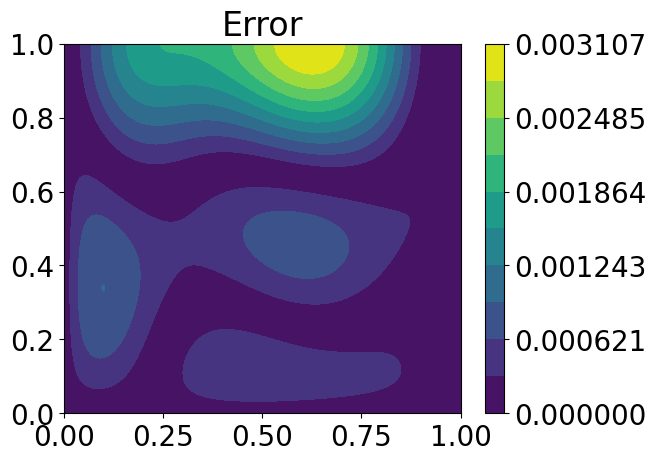

In [12]:
# test the solution
sol_test = torch.zeros(npt2,npt2)
Ntest = torch.numel(sol_test)
for i in range(npt2):
    for j in range(npt2):
        sol_test[i,j] = SolutionModel(xtest_grid[i,j],ytest_grid[i,j],W)
plt.figure()
plt.contourf(xtest_grid,ytest_grid,sol_test,torch.arange(sol_min-0.0005,sol_max+0.05,0.1*(sol_max-sol_min)))   
plt.colorbar()
plt.title("Computed Solution")
plt.savefig("NumericalSol.pdf")
# compare with the exact solution
error = torch.abs(sol_test - sol_exact)
error_vector = torch.reshape(error,(Ntest,1))
error_max = torch.max(error_vector)
plt.figure()
plt.contourf(xtest_grid,ytest_grid,error,torch.arange(0,error_max+0.00002,error_max*0.1))  
plt.colorbar()
plt.title("Error")
print("Max error = ",torch.max(error_vector))
print("Mean error = ",torch.mean(error_vector))
print("RMS error = ",torch.sqrt(torch.mean(error_vector.pow(2))))
plt.savefig("NNError.pdf")